In [128]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from googletrans import Translator
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk.tag import pos_tag
from wordcloud import wordcloud
import matplotlib.pyplot as plt
import textblob
import decimal
import seaborn as sns

## Loading the Data

### Reviews


In [89]:

df_reviews = pd.read_csv("reviews.csv")

df_reviews.describe()
df_reviews.head()

,id,listing_id,date,reviewer_id,reviewer_name,comments
0,25218143,2384,2015-01-09,14385014,Ivan,it's a wonderful trip experience. I didn't exc...
1,28475392,2384,2015-03-24,16241178,Namhaitou,This is my first trip using Airbnb. I was a li...
2,30273263,2384,2015-04-19,26101401,Patrick,The reservation was canceled 80 days before ar...
3,30974202,2384,2015-04-30,26247321,Cristina,Sólo puedo decir cosas buenas de Rebecca. La h...
4,31363208,2384,2015-05-04,31293837,SuJung,Rebecca was an absolutely wonderful host.\n\nI...


### All 3 code blocks are included, but should be uncommented to run.  The results executed on this notebook are from Sample 2.

In [90]:
#df_reviews_sub = df_reviews.iloc[233902:].copy()  # Sample # 3 (initial sample)
#df_reviews_sub = df_reviews.iloc[0:116837].copy() # Sample # 1
df_reviews_sub = df_reviews.iloc[116837:233902].copy() # Sample # 2
df_reviews_sub.reset_index(inplace=True)

In [91]:
df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...


In [92]:
df_reviews_sub.shape

(117065, 7)

In [93]:
df_reviews_sub.isna().sum()

index             0
id                0
listing_id        0
date              0
reviewer_id       0
reviewer_name     0
comments         75
dtype: int64

In [94]:
df_reviews_sub = df_reviews_sub.dropna()
df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...


In [95]:
df_reviews_sub.isna().sum()


index            0
id               0
listing_id       0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [96]:
# Check for non-null empty comments
blanks = []
for index, row in df_reviews_sub.iterrows():
    if len(row['comments']) == 0:
        blanks.append(index)
print(blanks)

[]


### Listings

In [97]:
df_listings = pd.read_csv("listings.csv")
print(len(df_listings))

8533


### We will remove all NaN values from the categorical ratings fields, as we are not interested in listings that aren't rated.  We will also remove any listings that are not in the city of Chicago.

In [98]:
df_listings.isna().sum()

id                                0
listing_url                       0
name                              0
description                     129
host_id                           0
host_since                        0
neighbourhood                    27
city                              3
state                            23
zipcode                          22
country_code                      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         3
bedrooms                          4
security_deposit               2086
cleaning_fee                    836
review_scores_rating           1244
review_scores_accuracy         1244
review_scores_cleanliness      1244
review_scores_checkin          1245
review_scores_communication    1246
review_scores_location         1245
review_scores_value            1245
instant_bookable            

In [99]:
cols = [ 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location', 'review_scores_value']

df_listings_null = df_listings[df_listings[cols].isna().any(1)]
df_listings = df_listings.drop(df_listings_null.index.tolist())

In [100]:
df_listings = df_listings[df_listings['city'] == 'Chicago']

In [101]:
df_listings.isna().sum()

id                                0
listing_url                       0
name                              0
description                      60
host_id                           0
host_since                        0
neighbourhood                     0
city                              0
state                            18
zipcode                          16
country_code                      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         3
bedrooms                          2
security_deposit               1517
cleaning_fee                    519
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value               0
instant_bookable            

In [102]:
listings_vals = df_listings['id'].unique()
print(len(listings_vals))


7257


### We now have 7257 unique listings from the df_listings dataframe.  We will check against the text reviews to ensure that no text reviews exist for an ID with no ratings.  As you can see from the shape comparisons before and after, this removed about 500 rows.

In [103]:
print(df_reviews_sub.shape)
df_reviews_sub = df_reviews_sub[df_reviews_sub['listing_id'].isin(listings_vals)]

(116990, 7)


In [104]:
df_reviews_sub.shape

(116929, 7)

# Text Preprocessing

## Translation 

### The code below cycles through the dataframe, and notes every row index that is not determined to be English.  It uses the langdetect Python package, which was one of the few I found that did not encounter translation rate limits when doing language detection.  However, it did occasionally throw an exception "No features in text".  I caught those exceptions and added them to a removal list, as the dataframe still contains plenty of text data.  


In [105]:
tobedropped = []
trans_lang = []
trans = []
for i in df_reviews_sub.index:
    try:
        temp = detect(df_reviews_sub.loc[i]['comments'])
        if temp != 'en':
            trans.append(i)
            trans_lang.append((i, temp))
    except:
        tobedropped.append(i)

In [106]:
print(len(trans))
print(len(df_reviews_sub))

4744
116929


### The following code translated the foreign language entries within the dataset, and replaced them with English translations.  However, the most functional Python translation modules access the Google Cloud Translation API, which for their free API currently has a rate limit and a character limit set every 24 hours.  The code referenced below translated a majority of the code, but once the limit was hit, the translation module would cease to function, although an Exception was not thrown.  For the purposes of the remaining code, I have removed any review identified as not 'en'.  This amounted to 4629 rows out of 116654 in this segment of the dataframe.

In [107]:
# df_reviews_sub = df_reviews_sub.drop(tobedropped)
# import time

# translator = Translator()
# num_chars = 0
# for i in trans[-10:]:
#     try:
#         if num_chars < 10:
#             temp_text = translator.translate(df_reviews_sub.loc[i]['comments'], dest= 'en').text
#             df_reviews_sub.loc[i]['comments'] = temp_text
#             num_chars +=1
#         else:
#             time.sleep(30)
#             num_chars = 0
#     except:
#         print("Exception at:", i)

# df_reviews_sub.to_csv('reviews_translated_end.csv')

   

In [108]:
df_reviews_sub = df_reviews_sub.drop(tobedropped)
df_reviews_sub = df_reviews_sub.drop(trans)

print(df_reviews_sub.shape)

(112029, 7)


## Modularization


### Because VADER utilizes punctuation and capitalization to infer strength of emotion, I am purposely not removing either of these elements before determining the composite score.  However, because we are attempting to capture the sentiment of individual topics, we do need the reviews to be a bit more granular, as one review could have multiple sentiments on multiple subjects.  I chose to break up the review by sentence, as complete tokenization would make it difficult to determine the sentiment/topic relationship.  The data will be tokenized later.


In [109]:
import re

# article_content contains all the article's paragraphs
# in this case, a single paragraph.

individ_comments = []

for index, row in df_reviews_sub.iterrows():
    comment_sentences = []
    comment_sentences += re.split("(?<=[.!?])\s+", row['comments'])
    individ_comments.append(comment_sentences)

df_reviews_sub['break'] = individ_comments
df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments,break
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...,"[I had a lovely stay at Justine's place!, She'..."
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...,[I would like to say we had a wonderful experi...
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...,"[Jessica was great., very attentive and access..."
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...,"[The condo was amazing., It was very spacious ..."
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...,[Jessica was available on texts most of the ti...


In [110]:
sid = SentimentIntensityAnalyzer()
sentimentScore = []

for i in df_reviews_sub['break']:
    sentence_Score = []
    for j in i:
        sentence_Score.append(sid.polarity_scores(j)['compound'])

    sentimentScore.append(sentence_Score)

df_reviews_sub['sentiment_score_comm'] = sentimentScore
df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments,break,sentiment_score_comm
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...,"[I had a lovely stay at Justine's place!, She'...","[0.6239, 0.7688, 0.5859, 0.5244]"
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...,[I would like to say we had a wonderful experi...,[0.9781]
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...,"[Jessica was great., very attentive and access...","[0.6249, 0.0, 0.0, 0.4404, 0.5719, 0.0, -0.353..."
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...,"[The condo was amazing., It was very spacious ...","[0.5859, 0.4576, 0.5994, 0.7964]"
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...,[Jessica was available on texts most of the ti...,[0.9062]


### The following code is used to transform the VADER polarity score into an integer value reflecting the AirBnB category rankings.

In [111]:
def transformRange (value, r1, r2):
    if value == 1:
        return 10
    if value == 0:
        return 5
    if value == -1:
        return 0
    scale = (r2[max] - r2[min]) / (r1[max] - r1[min])
    
     
    output = decimal.Decimal((value - r1[min]) * scale)
    return round(output)


df_reviews_sub['sent_bin'] = df_reviews_sub['sentiment_score_comm'].apply(lambda x: [transformRange(y, {min: -1, max: 1}, {min: 0, max: 10}) for y in x])

In [112]:
stop = nltk.corpus.stopwords.words('english')

In [113]:
# remove upper case values
df_reviews_sub['break'] = df_reviews_sub['break'].map(lambda x: list(map(str.lower, x)))

df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments,break,sentiment_score_comm,sent_bin
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...,"[i had a lovely stay at justine's place!, she'...","[0.6239, 0.7688, 0.5859, 0.5244]","[8, 9, 8, 8]"
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...,[i would like to say we had a wonderful experi...,[0.9781],[10]
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...,"[jessica was great., very attentive and access...","[0.6249, 0.0, 0.0, 0.4404, 0.5719, 0.0, -0.353...","[8, 5, 5, 7, 8, 5, 3, 8, 7, 7, 5]"
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...,"[the condo was amazing., it was very spacious ...","[0.5859, 0.4576, 0.5994, 0.7964]","[8, 7, 8, 9]"
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...,[jessica was available on texts most of the ti...,[0.9062],[10]


In [114]:
# tokenize each review and remove stopwords

df_reviews_sub['stop'] = df_reviews_sub['break'].apply(lambda x: [' '.join([word for word in list.split() if not word in stop]) for list in x ] )

df_reviews_sub['token'] = df_reviews_sub['stop'].apply(lambda x: list(map(word_tokenize, x)))


In [115]:
df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments,break,sentiment_score_comm,sent_bin,stop,token
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...,"[i had a lovely stay at justine's place!, she'...","[0.6239, 0.7688, 0.5859, 0.5244]","[8, 9, 8, 8]","[lovely stay justine's place!, friendly welcom...","[[lovely, stay, justine, 's, place, !], [frien..."
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...,[i would like to say we had a wonderful experi...,[0.9781],[10],[would like say wonderful experience chicago r...,"[[would, like, say, wonderful, experience, chi..."
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...,"[jessica was great., very attentive and access...","[0.6249, 0.0, 0.0, 0.4404, 0.5719, 0.0, -0.353...","[8, 5, 5, 7, 8, 5, 3, 8, 7, 7, 5]","[jessica great., attentive accessible though l...","[[jessica, great, .], [attentive, accessible, ..."
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...,"[the condo was amazing., it was very spacious ...","[0.5859, 0.4576, 0.5994, 0.7964]","[8, 7, 8, 9]","[condo amazing., spacious extremely clean., ap...","[[condo, amazing, .], [spacious, extremely, cl..."
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...,[jessica was available on texts most of the ti...,[0.9062],[10],"[jessica available texts times, house clean ni...","[[jessica, available, texts, times, ,, house, ..."


In [116]:
#lemmatize
# initiate nltk lemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

# lemmatize words

df_reviews_sub['lemmatize'] = df_reviews_sub['token'].apply(lambda x: [[wordnet_lemmatizer.lemmatize(z) for z in y] for y in x]) 

# check for any reviews that have been stopworded into oblivion
blanks = []
for index, row in df_reviews_sub.iterrows():
    if len(row['lemmatize']) == 0:
        blanks.append(index)

df_reviews_sub = df_reviews_sub.drop(blanks)

### Now that we have the tokenized, lemmatized version of the review corpus, with stopwords removed, I created a word cloud so that I could begin to identify the most common words in my topic-specific word map.  

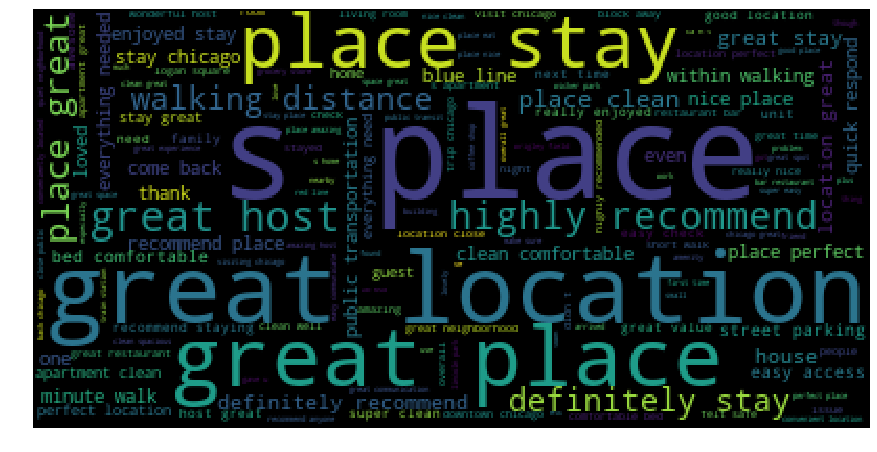

In [117]:

flat_list =  [item for listlist in df_reviews_sub['lemmatize'] for sublist in listlist for item in sublist]
flat_list = ' '.join(flat_list)
wordcloud2 = wordcloud.WordCloud().generate(flat_list)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

### The word map below was created manually both via the word cloud above, and manual scanning through the original dataset.  Each sentence will only match to the first topic encountered, even if it contains multiple topics.


In [118]:
word_maps = {'accuracy':['perfect', 'stunning', 'expectation','exactly','detail','picture','describe', 'photo', 'terrible', 'advertised','advertise','noise', 'lack','missing','expected','standard', 'wrong'], 'cleanliness':['clean', 'prepare', 'cozy', 'stains', 'beautiful','spotless', 'fresh', 'musty', 'moldy','infested','neat','dirty','beautiful','atmosphere','organized'], 'checkin':['check-in', 'easy', 'early', 'late', 'code', 'key','effortless'], 'communication':['host', 'accommodating', 'nice', 'communication', 'help', 'responsive', 'communicate','welcome','respond','attentive', 'issue','concern','hospitality', 'need','inconvenience', 'fix', 'unresponsive', 'communicative', 'dispute','tips', 'wait', 'waiting','blame', 'available','response','hiccup','suggestion','suggest'], 'location':['space', 'place', 'neighborhood', 'chicago', 'downtown', 'walking distance', 'close', 'restaurant', 'city', 'parking', 'location', 'access', 'close', 'convenient', 'park', 'museum', 'shopping', 'bar', 'theater', 'transportation','train','concert', 'United', 'game','grocery', 'quiet', 'coffee', 'safe', 'lake', 'near', 'transit','loitering','connection', 'bakery','upscale','drive', 'walk', 'UChicago','security', 'Cubs','apartment','house','view','central','hostel','hotel','CTA'], 'value':['spacious', 'value', 'price', 'fee', 'amenity', 'feature', 'design','stylish','shampoo', 'comfy', 'television', 'wifi', 'wi','accommodation','decor', 'large', 'facilities','comfortable','thoughtful', 'gift','snack','touch','welcoming','worth','pleasant', 'service']}

word_val_list = []
count_blanks = 0

for review in df_reviews_sub['lemmatize']:
    subj_vals = []
    for sentence in review:
        appended = False
        for word in sentence:
            for k in word_maps:
                if word in word_maps[k] and appended == False:
                    subj_vals.append(k)
                    appended = True
                    break
        if appended == False:
            subj_vals.append("other")  
    word_val_list.append(subj_vals)

df_reviews_sub['subjects'] = word_val_list



### This function creates a dictionary based on the subject and average polarity bin value for each review...

In [119]:
def make_dict(key_list, val_list):
    dict = {}
    if len(key_list) != len(val_list):
        print("Keys", key_list)
        print("Vals", val_list)
        return dict
    for k in range(len(key_list)):
        if key_list[k] not in dict:
            dict[key_list[k]] = [val_list[k]]
        else:
            dict[key_list[k]].append(val_list[k])

    avg_dict = {k: int(sum(v)/len(v)) for k,v in dict.items()}
    return avg_dict

df_reviews_sub['res'] = df_reviews_sub.apply(lambda row: make_dict(row['subjects'], row['sent_bin']), axis = 1)


In [120]:
df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments,break,sentiment_score_comm,sent_bin,stop,token,lemmatize,subjects,res
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...,"[i had a lovely stay at justine's place!, she'...","[0.6239, 0.7688, 0.5859, 0.5244]","[8, 9, 8, 8]","[lovely stay justine's place!, friendly welcom...","[[lovely, stay, justine, 's, place, !], [frien...","[[lovely, stay, justine, 's, place, !], [frien...","[location, value, location, communication]","{'location': 8, 'value': 9, 'communication': 8}"
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...,[i would like to say we had a wonderful experi...,[0.9781],[10],[would like say wonderful experience chicago r...,"[[would, like, say, wonderful, experience, chi...","[[would, like, say, wonderful, experience, chi...",[location],{'location': 10}
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...,"[jessica was great., very attentive and access...","[0.6249, 0.0, 0.0, 0.4404, 0.5719, 0.0, -0.353...","[8, 5, 5, 7, 8, 5, 3, 8, 7, 7, 5]","[jessica great., attentive accessible though l...","[[jessica, great, .], [attentive, accessible, ...","[[jessica, great, .], [attentive, accessible, ...","[other, communication, communication, location...","{'other': 6, 'communication': 5, 'location': 6..."
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...,"[the condo was amazing., it was very spacious ...","[0.5859, 0.4576, 0.5994, 0.7964]","[8, 7, 8, 9]","[condo amazing., spacious extremely clean., ap...","[[condo, amazing, .], [spacious, extremely, cl...","[[condo, amazing, .], [spacious, extremely, cl...","[other, value, other, location]","{'other': 8, 'value': 7, 'location': 9}"
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...,[jessica was available on texts most of the ti...,[0.9062],[10],"[jessica available texts times, house clean ni...","[[jessica, available, texts, times, ,, house, ...","[[jessica, available, text, time, ,, house, cl...",[communication],{'communication': 10}


### The dictionaries are then expanded so that the information per review has it's own column.  Where a subject wasn't mentioned, we retain NaN so that these values will not be incorporated into the listing average for that category.

In [121]:
df_reviews_sub['res'].apply(pd.Series)
df_reviews_sub = pd.concat([df_reviews_sub.drop(['res'], axis = 1), df_reviews_sub['res'].apply(pd.Series)], axis = 1)
df_reviews_sub.head()

,index,id,listing_id,date,reviewer_id,reviewer_name,comments,break,sentiment_score_comm,sent_bin,...,token,lemmatize,subjects,location,value,communication,other,accuracy,cleanliness,checkin
0,116837,547679964,12159695,2019-10-15,3709372,Mallaury,I had a lovely stay at Justine's place! She's ...,"[i had a lovely stay at justine's place!, she'...","[0.6239, 0.7688, 0.5859, 0.5244]","[8, 9, 8, 8]",...,"[[lovely, stay, justine, 's, place, !], [frien...","[[lovely, stay, justine, 's, place, !], [frien...","[location, value, location, communication]",8.0,9.0,8.0,NaN,NaN,NaN,NaN
1,116838,68656134,12170773,2016-04-06,4422023,Dwayne,I would like to say we had a wonderful experie...,[i would like to say we had a wonderful experi...,[0.9781],[10],...,"[[would, like, say, wonderful, experience, chi...","[[would, like, say, wonderful, experience, chi...",[location],10.0,NaN,NaN,NaN,NaN,NaN,NaN
2,116839,69036281,12170773,2016-04-08,16569578,Naimish,Jessica was great. very attentive and accessi...,"[jessica was great., very attentive and access...","[0.6249, 0.0, 0.0, 0.4404, 0.5719, 0.0, -0.353...","[8, 5, 5, 7, 8, 5, 3, 8, 7, 7, 5]",...,"[[jessica, great, .], [attentive, accessible, ...","[[jessica, great, .], [attentive, accessible, ...","[other, communication, communication, location...",6.0,NaN,5.0,6.0,8.0,NaN,NaN
3,116840,69989174,12170773,2016-04-15,65467524,Elizabeth,The condo was amazing. It was very spacious an...,"[the condo was amazing., it was very spacious ...","[0.5859, 0.4576, 0.5994, 0.7964]","[8, 7, 8, 9]",...,"[[condo, amazing, .], [spacious, extremely, cl...","[[condo, amazing, .], [spacious, extremely, cl...","[other, value, other, location]",9.0,7.0,NaN,8.0,NaN,NaN,NaN
4,116841,70277659,12170773,2016-04-17,56990266,Pranith,Jessica was available on texts most of the tim...,[jessica was available on texts most of the ti...,[0.9062],[10],...,"[[jessica, available, texts, times, ,, house, ...","[[jessica, available, text, time, ,, house, cl...",[communication],NaN,NaN,10.0,NaN,NaN,NaN,NaN


### For each listing, the scores for each category are averaged and added to a dataframe alongside the listed category rating

In [122]:
listing_df = pd.DataFrame()
listing_df['location'] = df_reviews_sub.groupby('listing_id')['location'].mean()
listing_df['cleanliness'] = df_reviews_sub.groupby('listing_id')['cleanliness'].mean()
listing_df['communication'] = df_reviews_sub.groupby('listing_id')['communication'].mean()
listing_df['checkin'] = df_reviews_sub.groupby('listing_id')['checkin'].mean()
listing_df['accuracy'] = df_reviews_sub.groupby('listing_id')['accuracy'].mean()
listing_df['value'] = df_reviews_sub.groupby('listing_id')['value'].mean()
listing_df.index.name = "id"

cols = ['id','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication','review_scores_location','review_scores_value']
df_listing_sub = df_listings[cols]
listing_df.reset_index(inplace=True)
listing_df = listing_df.merge(df_listing_sub, how='left', on='id')


new_cols = ['id','accuracy','review_scores_accuracy','cleanliness','review_scores_cleanliness','checkin','review_scores_checkin','communication', 'review_scores_communication','location','review_scores_location','value','review_scores_value']

listing_df = listing_df[new_cols]
listing_df.head()

,id,accuracy,review_scores_accuracy,cleanliness,review_scores_cleanliness,checkin,review_scores_checkin,communication,review_scores_communication,location,review_scores_location,value,review_scores_value
0,12159695,NaN,10.0,NaN,9.0,NaN,10.0,8.000000,10.0,8.000000,10.0,9.000000,9.0
1,12170773,6.886364,10.0,8.388235,10.0,7.454545,10.0,7.477778,10.0,7.570896,10.0,7.666667,10.0
2,12201757,8.666667,10.0,8.333333,10.0,7.500000,10.0,8.000000,10.0,7.705882,10.0,8.500000,10.0
3,12202949,7.500000,10.0,8.666667,10.0,8.000000,10.0,7.200000,10.0,8.444444,10.0,7.333333,10.0
4,12218935,6.769231,10.0,8.666667,10.0,7.428571,10.0,8.313433,10.0,7.588235,10.0,8.425000,10.0


### The differences between the actual and the calculated scores are taken (if the calculated value is present), and the means of the differences are shown for the final result

In [123]:

output_diff = pd.DataFrame()
output_diff['id'] = listing_df['id'].copy()
output_diff['accuracy_diff'] = listing_df.apply(lambda x: abs(x['accuracy']-x['review_scores_accuracy']) if not np.isnan(x['accuracy']) else x['accuracy'], axis = 1)
output_diff['cleanliness_diff'] = listing_df.apply(lambda x: abs(x['cleanliness']-x['review_scores_cleanliness']) if not np.isnan(x['cleanliness']) else x['cleanliness'], axis = 1)
output_diff['checkin_diff'] = listing_df.apply(lambda x: abs(x['checkin']-x['review_scores_checkin']) if not np.isnan(x['checkin']) else x['checkin'], axis = 1)
output_diff['communication_diff'] = listing_df.apply(lambda x: abs(x['communication']-x['review_scores_communication']) if not np.isnan(x['communication']) else x['communication'], axis = 1)
output_diff['location_diff'] = listing_df.apply(lambda x: abs(x['location']-x['review_scores_location']) if not np.isnan(x['location']) else x['location'], axis = 1)
output_diff['value_diff'] = listing_df.apply(lambda x: abs(x['value']-x['review_scores_value']) if not np.isnan(x['value']) else x['value'], axis = 1)
display(output_diff)

diff_means = output_diff.mean(axis = 0)
diff_means = diff_means.drop(labels='id')
diff_means = diff_means.to_frame()
diff_means.columns = ["Mean Abs Diff"]
diff_means

,id,accuracy_diff,cleanliness_diff,checkin_diff,communication_diff,location_diff,value_diff
0,12159695,NaN,NaN,NaN,2.000000,2.000000,0.000000
1,12170773,3.113636,1.611765,2.545455,2.522222,2.429104,2.333333
2,12201757,1.333333,1.666667,2.500000,2.000000,2.294118,1.500000
3,12202949,2.500000,1.333333,2.000000,2.800000,1.555556,2.666667
4,12218935,3.230769,1.333333,2.571429,1.686567,2.411765,1.575000
...,...,...,...,...,...,...,...
1626,21772526,3.000000,1.615385,2.000000,2.312500,2.307692,1.857143
1627,21772553,3.250000,2.194444,2.750000,2.563218,1.991071,2.146341
1628,21782770,2.666667,2.000000,4.000000,3.000000,2.928571,3.000000
1629,21783333,3.138889,1.894737,2.736842,2.919540,2.477707,2.283333


,Mean Abs Diff
accuracy_diff,2.699403
cleanliness_diff,1.614411
checkin_diff,2.506694
communication_diff,2.448135
location_diff,2.436137
value_diff,1.930338


### Ultimately, I did not want to see results where the differences could be explained away by the thoroughness of the word map, or the number of reviews, and looking at the charts below, where we can see the category difference against both the review counts and the word map counts, it looks as if there is another factor that determines the true difference between categories.  This means that all of our methodologies have some merit in predicting the review ratings, and that although the ratings shown by AirBnB are high, the reviews do reflect similar content as far as subject matter and corresponding emotion

In [144]:
diff_means.reset_index(inplace=True)
diff_means.columns = ['category', 'Mean Abs Diff']

[Text(0, 0, 'accuracy_diff'),
 Text(0, 0, 'cleanliness_diff'),
 Text(0, 0, 'checkin_diff'),
 Text(0, 0, 'communication_diff'),
 Text(0, 0, 'location_diff'),
 Text(0, 0, 'value_diff')]

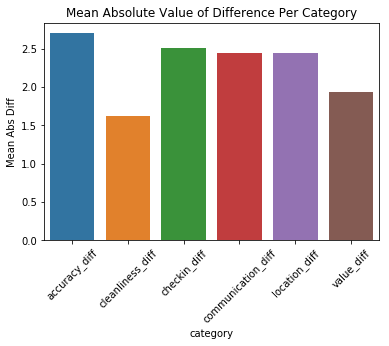

In [145]:
ax = sns.barplot(x='category', y='Mean Abs Diff', data=diff_means)
ax.set_title("Mean Absolute Value of Difference Per Category")
ax.set_xticklabels(labels=diff_means['category'], rotation = 45)

In [136]:
data = output_diff.count().to_frame()
data.reset_index(inplace = True)
data = data.drop(data.index[0])
data.columns = ['category', 'count']
data

,category,count
1,accuracy_diff,1412
2,cleanliness_diff,1474
3,checkin_diff,1387
4,communication_diff,1602
5,location_diff,1618
6,value_diff,1525


[Text(0, 0, 'accuracy_diff'),
 Text(0, 0, 'cleanliness_diff'),
 Text(0, 0, 'checkin_diff'),
 Text(0, 0, 'communication_diff'),
 Text(0, 0, 'location_diff'),
 Text(0, 0, 'value_diff')]

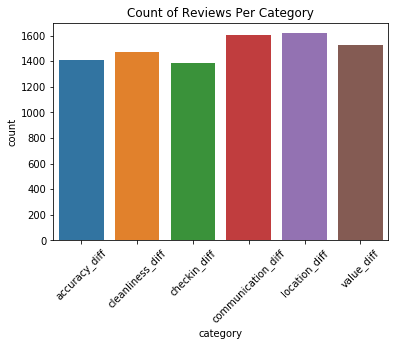

In [137]:
ax = sns.barplot(x='category', y='count', data=data)
ax.set_title("Count of Reviews Per Category")
ax.set_xticklabels(labels=data['category'], rotation = 45)

In [138]:
length_dict = {key: len(value) for key, value in word_maps.items()}
length_dict

{'accuracy': 17,
 'cleanliness': 15,
 'checkin': 7,
 'communication': 28,
 'location': 47,
 'value': 26}

In [142]:
word_map_len = pd.DataFrame.from_dict(length_dict, orient = 'index')
word_map_len.reset_index(inplace = True)

word_map_len.columns = ['category', 'word_count']

word_map_len

,category,word_count
0,accuracy,17
1,cleanliness,15
2,checkin,7
3,communication,28
4,location,47
5,value,26


[Text(0, 0, 'accuracy'),
 Text(0, 0, 'cleanliness'),
 Text(0, 0, 'checkin'),
 Text(0, 0, 'communication'),
 Text(0, 0, 'location'),
 Text(0, 0, 'value')]

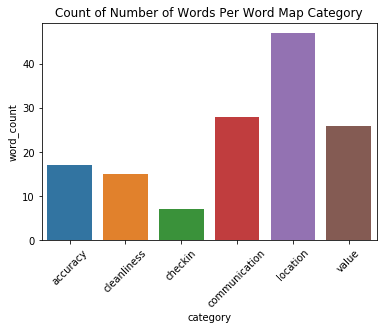

In [143]:
ax = sns.barplot(x='category', y='word_count', data=word_map_len)
ax.set_title("Count of Number of Words Per Word Map Category")
ax.set_xticklabels(labels=word_map_len['category'], rotation = 45)